<a href="https://colab.research.google.com/github/ryanmansoor/CIPA-FYP/blob/master/Cost_of_Interconnection_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation


In [1]:
!pip install overpy
!pip install mpu
!pip install geotiler

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for overpy: filename=overpy-0.4-cp36-none-any.whl size=45772 sha256=614829e475e934b21986271b9ef1b40e341e60d4bc9758c8613ea85582fefeca
  Stored in directory: /root/.cache/pip/wheels/10/53/c2/e6b6f97e7bb419193bd3aafbe38628666f0f93a1cec9dc521d
Successfully built overpy
     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 378kB 2.8MB/s 
     |████████████████████████████████| 481kB 12.7MB/s 
     |████████████████████████████████| 1.2MB 17.5MB/s 
     |████████████████████████████████| 256kB 20.6MB/s 
     |████████████████████████████████| 153kB 21.3MB/s 
  Created wheel for geotiler: filename=geotiler-0.14.4-cp36-none-any.whl size=53637 sha256=17a1fde2c90e2d43d16ce07c641f4bab5981b5c76cce077eda825d281409f582
  Stored in directory: /root/.cache/pip/wheels/78/0d/ed/77213e2c6f74d27b49ca99c0e1a93188a9421198d4069f43d1
  Created wheel for cytoolz: filename=cytoolz-0.10.1-cp36-cp36m-linu

In [0]:
import mpu
import sys
import math
import geotiler
import csv
import os
import time
from matplotlib import pyplot as plt
import overpy
api = overpy.Overpass()


In [0]:
# OSM Map colors and Legend (Assosciated Costs Based on: https://www.wecc.org/Reliability/2014_TEPPC_Transmission_CapCost_Report_B+V.pdf)
osm_map_color_dict =	{
    
  "#e892a2": ("Motor Way", 1.70),
  "#dc2a67": ("Motor Way", 1.70),
  "#f9b29c": ("Main Road", 1.60),
  "#fcd6a4": ("Main Road", 1.60),
  "#f7fabf": ("Main Road", 1.60),
  "#c84e2f": ("Main Road", 1.60),
  "#a06b00": ("Main Road", 1.60),
  "#707d05": ("Main Road", 1.60),
  "#a97e27": ("Track", 1.2),
  "#57b257": ("Bridleway", 1.2),
  "#7a7cf6": ("Cycleway", 1.2),
  "#fa7671": ("Footway", 1.2),
  "#999999": ("Railway", 1.5),
  "#bcbcbc": ("Railway", 1.5),
  "#777777": ("Railway", 1.5),
  "#333333": ("Light Rail and Tram", 1.7),
  "#b7b7b7": ("Cable Car and Chairlift", 1.75),
  "#bdbdcd": ("Airport Runway and Taxiway", 5),
  "#cc99ff": ("Airport Apron and Terminal", 5),
  "#e3aeec": ("Administrative Boundary", 1.0),
  "#8dc56c": ("Forest", 2.25),
  "#aed1a0": ("Wood", 2.25),
  "#b5e3b5": ("Golf Course", 5),
  "#b6fdb6": ("Park", 3),
  "#aedfa3": ("Park", 3),
  "#cccccc": ("Residential Area", 1.49),
  "#cfeca8": ("Common and Meadow", 1.0),
  "#f1dada": ("Retail Area", 1.69),
  "#ffaeb9": ("Industrial Area", 1.49),
  "#efc8c8": ("Commercial Area", 1.59),
  "#ffffc0": ("Heathland", 1),
  "#b5d0d0": ("Lake and Reservoir", 5),
  "#ead8bd": ("Farm", 1),
  "#9d9d6c": ("Brownfield Site", 1.59),
  "#aacbaf": ("Cemetery", 1.8),
  "#c8b084": ("Allotments", 1),
  "#8ad3af": ("Sports Pitch", 3),
  "#33cc99": ("Sports Centre", 5),
  "#abdf96": ("Nature Reserve", 5),
  "#cee3c5": ("Nature Reserve", 5),
  "#e18f8f": ("Military Area", 5),
  "#f0f0d8": ("School and University", 5),
  "#eef0d5": ("Wetland", 1.2),
  "#cc9999": ("Significant Building", 5),
  "#d08f55": ("Summit and Peak", 2.25),
  "#bdbece": ("Motorway", 1.70),
  "#9a9ab1": ("Motorway", 1.70),
  "#c8d8c8": ("Trunk Road", 1.5),
  "#abb5a4": ("Trunk Road", 1.5),
  "#d8c8c8": ("Primary Road", 1.5),
  "#f0e3e3": ("Primary Road", 1.5),
  "#d4b6b7": ("Primary Road", 1.5),
  "#dadacc": ("Secondary Road", 1.5),
  "#ededc8": ("Secondary Road", 1.5),
  "#c8b48a": ("Secondary Road", 1.5),
  "#9f6f0f": ("Track", 1.2),
  "#0100fe": ("Cycleway", 1.2),
  "#fe0000": ("National Cycleway", 1.2),
  "#28c8fe": ("Regional Cycleway", 1.2),
  "#b2b2ff": ("Local Cycleway", 1.2),
  "#bd6d6e": ("Footway", 1.2),
  "#cde1c4": ("Forest", 2.25),
  "#bcdd92": ("Common and Meadow", 1),
  "#f2efe8": ("Urban Area", 1.59),
  "#f4e1ec": ("Urban Area", 1.59),
  "#e0dfdf": ("Urban Area", 1.59),
  "#f2efe9": ("Urban Area", 1.59),
  "#f4f2ed": ("Urban Area", 1.59),
  "#f7f5f1": ("Urban Area", 1.59),
  "#add19e": ("Nature Reserve", 5),
  "#aad3df": ("Water", 5),
  "#d1d1d0": ("Common and Meadow", 1),
  "#ffffff": ("Road", 1.2),
  "#d9d0c9": ("Building", 1.59),
  "#bfb0a4": ("Building", 1.59),
}

In [0]:
# The Following Node Datatype is created to store each segment of the map, to perform graph search
class Node():

    def __init__(self, i=0, j=0, f=0, g=0, h=0, coordinates=[0, 0], cost=1.59):
        self.i = i # each node must know which grid index it is in
        self.j = j # therefore i and j are required
        self.f = f # the cost of the cell, f = g + h
        self.g = g # cost up to current cell
        self.h = h # heuristic 
        self.neighbours = []
        self.parent = None

        self.coordinates = coordinates
        self.cost = cost

    def addNeighbours(self, grid):
      i = self.i
      j = self.j
      rows = len(grid)
      cols = len(grid[0])

      if i != 0:
        if j != (cols - 1):
            self.neighbours.append(grid[i-1][j+1])
        if j != 0:
            self.neighbours.append(grid[i-1][j-1])
        self.neighbours.append(grid[i-1][j])

      if i != (rows - 1): 
        if j != (cols - 1):
            self.neighbours.append(grid[i+1][j+1])
        if j != 0:
            self.neighbours.append(grid[i+1][j-1])
        self.neighbours.append(grid[i+1][j])
      
      if j != (cols - 1):
        self.neighbours.append(grid[i][j+1])

      if j != 0:  
        self.neighbours.append(grid[i][j-1])

In [0]:
def get_closest_connection_point(start, radius=5000):
    """
    :param start: Lat Lng Coordinates of hypothetical plant
    :return: Coordinates and properties of closest substation using the Overpy API
    """
    
    substations = []  
    while len(substations) == 0:
        print('Searching for substations at radius {}km'.format(radius/1000))
        # Get nodes with tag substation
        response = api.query('node[power=substation](around:{2},{0},{1}); out;'
                         .format(start[0], start[1], radius))
        nodes=response.nodes
        for node in nodes:
          substations.append((float(node.lat), float(node.lon)))
        # Get ways with tag substation
        response = api.query('way[power=substation](around:{2},{0},{1}); out center;'
                         .format(start[0], start[1], radius))
               
        for way in response.ways:
          substations.append((float(way.center_lat), float(way.center_lon)))
          
        radius += 5000

        if radius == 50000:
            print('No results found within radius of 50000')
            n_responses = 1

    if len(substations) > 0:
        min_dist = 100000        
        c = 0
        for substation in substations:
            dist = mpu.haversine_distance(start, substation)
            print(c, "Found substation at:",substation, " Distance (km):", dist)
            c+=1
 
        return substations
    else:
        print("No results")


In [0]:
def padded_bbox(start, end, scale_ratio):
    """
    Takes 2 coordinates and generates a bbox with some added margin.
    :param start: Starting lat lng Coordinate (plant)
    :param end: Ending lat lng Coordinate (Tower or Substation)
    :param scale_ratio: Ratio of (padded bbox height): (unpadded bbox height)
    :return: padded bounding box, margin, center coordinates
    """
    center = [(start[0]+end[0])/2, (start[1]+end[1])/2] # center coordinates
    vertical_dist_lat = abs(start[0]-end[0])
    horizontal_dist_lon = abs(start[1]-end[1])

    # bounding area of image, in lat lng coordinates adding a padding of 0.5/2 at each border 
    bot = center[0]-(scale_ratio/2)*vertical_dist_lat
    L = center[1]-(scale_ratio/2)*horizontal_dist_lon
    top = center[0]+(scale_ratio/2)*vertical_dist_lat
    R = center[1]+(scale_ratio/2)*horizontal_dist_lon
    margin = (scale_ratio - 1)/2
    bbox = L, bot, R, top # Bounding box corners of map image, in coordinates
    return bbox, margin, center

In [0]:
def gen_grid(start, end, zoom_level=16, scale_ratio=2, node_dist=15):

    """
    Generates a square grid containing coordinates encompassing start and end.
    :param start: Starting Coordinate (plant)
    :param end: Ending Coordinate (Tower or Substation)
    :param scale_ratio: Ratio of (padded bbox height): (unpadded bbox height)
    :return: 2D list containing coordinates
    """

    bbox, margin, center = padded_bbox(start, end, scale_ratio) # retrieve a lat lng bounding box encompassing start and end coordinates within a margin, along with center
    
    # The distance in meters of 1 pixel at a given zoom level (e.g 16) as output by geotiler:
    dist_per_pix = 40075016.686 * math.cos(math.radians(center[0])) / (2**(zoom_level + 8)) # 40075016.686 is the circumference of the earth in meters
    print('Distance per pixel', dist_per_pix)
    


    # The number of pixels along one axis of each square cell:
    pix_vals, width, height = gen_map(bbox, start, end, zoom_level=zoom_level) # generate image of bounding area, labelling start and end coordinates. Retrieves pixel values in a 2D array.
    grid_dist_pix = int(round(node_dist/dist_per_pix)) # node_distm is the width of the overhead line to be constructed, the grid cells are therefore always 38mx38m
    
    
    n_grids_width = int(round(width/grid_dist_pix)) # Width of grid in no. of cells
    n_grids_height = int(round(height/grid_dist_pix)) # Height of grid in no. of cells
    lat_step_size = (bbox[3]-bbox[1]) / n_grids_height # Height of cell in latitude degrees
    lon_step_size = (bbox[2]-bbox[0]) / n_grids_width # Width of cell in longitude degrees
    
    


    # Figuring out which index of the graph contains the start point and the end point:
    if start[0] < end[0]: #if the start coordinate is below the end coordinate
        if start[1] < end[1]: #if the start coordinate is to the left of the end coordinate
            start_idx = [int(round(((scale_ratio-margin)/scale_ratio)*n_grids_height)), int(round((margin/scale_ratio)*n_grids_width))] # the index of the start coordinate is at the bottom left of the 2D list (- padding)
            end_idx = [int(round((margin/scale_ratio)*n_grids_height)), int(round(((scale_ratio-margin)/scale_ratio)*n_grids_width))]
        else:
            start_idx = [int(round(((scale_ratio-margin)/scale_ratio)* n_grids_height)), int(round(((scale_ratio-margin)/scale_ratio)* n_grids_width))]
            end_idx = [int(round((margin/scale_ratio) * n_grids_height)), int(round((margin/scale_ratio) * n_grids_width))]
    else:
        if start[1] < end[1]:
            start_idx = [int(round((margin/scale_ratio)*n_grids_height)), int(round((margin/scale_ratio)*n_grids_width))]
            end_idx = [int(round(((scale_ratio-margin)/scale_ratio)*n_grids_height)), int(round(((scale_ratio-margin)/scale_ratio)*n_grids_width))]
        else:
            start_idx = [int(round((margin/scale_ratio) * n_grids_height)), int(round(((scale_ratio-margin)/scale_ratio) * n_grids_width))]
            end_idx = [int(round(((scale_ratio-margin)/scale_ratio) * n_grids_height)), int(round((margin/scale_ratio) * n_grids_width))]

    grid = [[0] * n_grids_width for i in range(n_grids_height)] # create empty grid
    lat = bbox[3] # top most latitude
    
    idx_out_of_bounds = {} # using a dict here so that when the same column triggers an idx out of bounds error multiple times it gets recorded only once

    for row in range(len(grid)): # go through the grid
        lon = bbox[0] # left most longitude
        for column in range(len(grid[row])): # for every cell in the grid
            cell_cost = [] # create an empty list called cell cost
            for row_pix in range(grid_dist_pix):
                for col_pix in range(grid_dist_pix): # for every pixel that belongs in the cell, append the pixel cost to the cell cost list, ignoring unknown colours
                    pix_row_idx = row*grid_dist_pix + row_pix
                    pix_col_idx = column*grid_dist_pix + col_pix
                    try:
                        color = pix_vals[pix_row_idx][pix_col_idx]
                    except IndexError:
                      idx_out_of_bounds[pix_col_idx] = 1
                      continue
                    color = '#%02x%02x%02x' % color[:3] # Convert pixel values from RGB to HEX to use in hashmap
                    # retrieve pixel cost using pixel colour  
                    try:
                        pix_cost = osm_map_color_dict[color][1]
                        cell_cost.append(pix_cost)
                        # if pix_cost<1.4:
                        #   print(osm_map_color_dict[color][0])
                    except KeyError:
                        # print("Pixel Colour", color, "Not found")
                        continue
            if len(cell_cost)==0:
                cost = 1.59
            else:              
                cost = sum(cell_cost)/len(cell_cost) # take the cell cost to be the average of the pixel costs in that cell

            new_node = Node(i = row, j = column, coordinates=[lat, lon], cost=cost) # Create a new node for that cell with its cost and coordinates and place it in the grid. Continue for the whole grid.
            grid[row][column] = new_node

            lon += lon_step_size

        lat -= lat_step_size
    if idx_out_of_bounds:
      print("Index out of bounds error.", len(idx_out_of_bounds),  "pixel column(s) were not found. It is expected that due to rounding in dist_per_pix, there were 1 or 2 pixel rows or columns less than calculated.")
    
    for i in range(len(grid)):
      for j in range(len(grid[0])):
        grid[i][j].addNeighbours(grid)

    return grid, start_idx, end_idx, bbox


In [0]:
def gen_map(bbox, start, end, zoom_level=16, shortest_path=None, heat_map=False):
    fig = plt.figure(figsize=(20, 20))
    ax = plt.subplot(111)

    # download background map using OpenStreetMap
    mm = geotiler.Map(extent=bbox, zoom=zoom_level)

    img = geotiler.render_map(mm)
    ax.imshow(img)
    width, height = img.size
    pixels = list(img.getdata())
    pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]
    # plot custom points
    
    if heat_map:
      for row in range(len(map_grid)):
        for col in range(len(map_grid[row])):
          y, x = map_grid[row][col].coordinates
          x, y = mm.rev_geocode((x,y))
          if (map_grid[row][col].cost < 1.4):
            ax.scatter(x, y, c='green', edgecolor='none', s=10, alpha=0.9)
          if (map_grid[row][col].cost > 1.4 and map_grid[row][col].cost <=1.58):
            ax.scatter(x, y, c='yellow', edgecolor='none', s=10, alpha=0.9)
          if (map_grid[row][col].cost > 1.58 and map_grid[row][col].cost<=1.7):
            ax.scatter(x, y, c='orange', edgecolor='none', s=10, alpha=0.9)
          if (map_grid[row][col].cost > 1.7):
            ax.scatter(x, y, c='red', edgecolor='none', s=10, alpha=0.9)
          if (row == start_idx[0] and col == start_idx[1]):
            ax.scatter(x, y, c='blue', edgecolor='none', s=10, alpha=0.9)
          if (row == end_idx[0] and col == end_idx[1]):
            ax.scatter(x, y, c='blue', edgecolor='none', s=10, alpha=0.9)
            
    x0, y0 = start[1], start[0]
    x1, y1 = end[1], end[0]
    points = ((x0, y0), (x1, y1))
    x, y = zip(*(mm.rev_geocode(p) for p in points))
    plt.text(x[0], y[0], 'start')
    plt.text(x[1], y[1], 'end')
    if shortest_path is None:
      ax.scatter(x, y, c='red', edgecolor='none', s=10, alpha=0.9)
    else:
      for node in shortest_path:
        y, x = node.coordinates
        x, y = mm.rev_geocode((x,y))
        ax.scatter(x, y, c='black', edgecolor='none', s=10, alpha=0.9)
      plt.show()
      fig.savefig('shortest_path.jpg')
    plt.close()

    if shortest_path is None:
      return pixels, width, height

In [0]:
def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist  

def heuristic(x1,y1,x2,y2):
    # This is the octile distance between the node and the end 
    # D = 1
    # D2 = math.sqrt(2)
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)

    # return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)
    return (dx + dy) + (math.sqrt(2) - 2) * min(dx, dy)

In [0]:
# A* search algorithm for least cost path
def A_star_search(grid, start_idx, end_idx,
  k, contrusct_cost_per_m, cbl_cost_per_m, node_dist):
    open_set = []
    closed_set = []
    start = grid[start_idx[0]][start_idx[1]]
    end = grid[end_idx[0]][end_idx[1]]
    open_set.append(start)


    while(len(open_set) > 0):

      winner = 0;
      for i in range(len(open_set)):
        if(open_set[i].f < open_set[winner].f):

          winner = i
      current = open_set[winner]

      if(current==end):
        path = []
        temp = current
        path.append(temp)
        while (temp.parent is not None):
          path.append(temp.parent)
          temp = temp.parent

        print("DONE!") 
        return path

      open_set.remove(current)
      closed_set.append(current)
      

      neighbours = current.neighbours
      for neighbour in neighbours:
        if not neighbour in closed_set:
            dist = calculateDistance(current.i, current.j, neighbour.i, neighbour.j)
            tempg = current.g +
             (neighbour.cost*construct_cost_per_m + cbl_cost_per_m)*node_dist*dist
            #print('neighbour added to closed set')
            if neighbour in open_set:
                #print('neihgbour already in open set')
                if (tempg < neighbour.g):
                    neighbour.g = tempg
                    #print('Neighbour g updated')
            else:
                neighbour.g = tempg
                open_set.append(neighbour)
                #print('Neighbour added to open_set')
            
            neighbour.h = k*heuristic(neighbour.i, neighbour.j, end.i, end.j)
            neighbour.f = neighbour.g + neighbour.h

            if neighbour.parent is None:
              neighbour.parent = current
            elif current.f < neighbour.parent.f:
              neighbour.parent = current
            


In [0]:
def add_row(csvfile, row, header):
  if os.path.exists(csvfile):
    
    with open(csvfile,'a') as fd:
      writer = csv.writer(fd)
      writer.writerow(row)
      
  else:
    with open(csvfile,'a+') as fd:  
      writer = csv.writer(fd)
      writer.writerow(header)
      writer.writerow(row)


In [0]:
def cable_cost_per_m(P, V):
  I = P*1000/(1.732*V*0.8)   #1.732 is sqrt(3) and 0.8 is the power factor
  A = (I/22.9)**(1/0.616)  #Cable area with respect to current
  cbl_cost_per_m = (171*A - 988)/1000   #Cable area to cost
  return cbl_cost_per_m, I, A

In [0]:
def calc_cost(P, V, zoom_level, shortest_path, construct_cost_per_m, node_dist):
  cable_dist = 0
  terrain_mult = 0
  for node in shortest_path:
    if node.parent is not None:
          dist = calculateDistance(node.i, node.j, node.parent.i, node.parent.j)
          cable_dist += dist
          terrain_mult += dist*node.cost
    
  terrain_mult = terrain_mult/cable_dist
  cable_dist = node_dist*cable_dist
  total_cost = shortest_path[0].g

  row_cost = 0.1*total_cost
  gov_cost = 0.2*total_cost
  ftotal_cost = total_cost+row_cost+gov_cost
  cbl_cost_per_m, current, cable_area = cable_cost_per_m(P, V) 
  print("#------------# INPUTS #------------#")
  print("k:", k)
  print("Zoom Level:", zoom_level)
  print("Power (MW):", P)
  print("Voltage (kV):", V)
  print("#------------# OUTPUTS #------------#")
  print("Expected Current Flow (A):", current)
  print("Expected Cable Cross Section (sq. mm) :", cable_area)
  print("Cable Cost per Meter (USD/m):", cbl_cost_per_m)
  print("Construction Cost per Meter (USD/m)", construct_cost_per_m)
  print("Cable Length (m):", cable_dist)
  print("Average Terrain Multiplier", terrain_mult)
  print("Effective Construction Distance (m):", cable_dist*terrain_mult)
  print("Sub Total Cost of Line (USD):", total_cost)
  print("ROW Area (sq. m):", node_dist*cable_dist)
  print("ROW Cost (10% of subtotal cost):", row_cost)
  print("Gov. License Cost (20% of total cost):", gov_cost)
  print("Total Cost:", ftotal_cost)

  result = [P, V, current, cable_area, cbl_cost_per_m, construct_cost_per_m, cable_dist, terrain_mult, cable_dist*terrain_mult, total_cost, node_dist*cable_dist, row_cost, gov_cost, ftotal_cost]
  
  return result


# Processing

In [16]:
#-------------------# Get Closest Substation (Overwrite substation coordinates if desired) #-----------------#
plant_location = (52.99863, -2.6018)
# plant_location = [52.99863, -2.6018]
# Start coordinates of power plant to be built (latitude, longitude)

#plant_location = (51.62403,-1.25469)
substations = get_closest_connection_point(plant_location, radius=10000)


Searching for substations at radius 10.0km
0 Found substation at: (52.9733052, -2.6753066)  Distance (km): 5.669374188849838
1 Found substation at: (52.9804297, -2.7071026)  Distance (km): 7.333215063562246
2 Found substation at: (53.0769757, -2.5527026)  Distance (km): 9.309597034391421
3 Found substation at: (53.0332208, -2.6358564)  Distance (km): 4.470375279623882
4 Found substation at: (53.0004775, -2.589998)  Distance (km): 0.8160641243063055
5 Found substation at: (52.9959604, -2.489149)  Distance (km): 7.544780557434122


In [0]:
#-------------------# Select Substation From List #-----------------#
substation_location = substations[1]

In [18]:
#-------------------# Inputs #-----------------#
# Only the following variables are mandatory
Capacity = 10                     # Capacity of plant in MW
Voltage = 11                      # Voltage level of connection in kV

# Optional Variables
cost_per_pole = 1992              # USD cost of materials and labour for erecting a single utility pole
pole_spacing = 75.1               # Distance between poles in meters (91m in rural areas, 38m in urban areas in the UK)
k = 0                   # This is the weighting of the heuristic with respect to g score
node_dist = 38                    # Granularity, the distance between nodes in meters reduce to increase granulairty
zoom_level = 16                    # Granularity, the zoom level of the image increase to increase granularity


#-------------------# Generate Grid With Costs #-----------------#
start = time.time()
map_grid, start_idx, end_idx, bounding_box = gen_grid(plant_location, substation_location, zoom_level=zoom_level, node_dist=node_dist)
end = time.time()
gen_grid_time = end - start
print('Grid generation time (s):', gen_grid_time)

#-------------------# Search for Shortest Path #-----------------#
construct_cost_per_m = cost_per_pole/pole_spacing 
cbl_cost_per_m, I, A = cable_cost_per_m(P=Capacity, V=Voltage)
start = time.time()
shortest_path = A_star_search(map_grid, start_idx, end_idx, k,  construct_cost_per_m, cbl_cost_per_m, node_dist=node_dist)
end = time.time()
search_time = end - start
print('Search Time (s):', search_time)
n_nodes = len(map_grid)*len(map_grid[0])
print('No. of nodes:', n_nodes)

Distance per pixel 1.4378783286295629
Grid generation time (s): 44.52782344818115
DONE!
Search Time (s): 42.81615471839905
No. of nodes: 40716


In [25]:
#-------------------# Cost Calculation #-----------------#
result = calc_cost(Capacity, Voltage, zoom_level, shortest_path, construct_cost_per_m=construct_cost_per_m, node_dist = node_dist) # Enter Power Plant Sizes here (e.g 10MW, 11kV)
fghrow = [k, zoom_level, n_nodes, gen_grid_time, search_time]
add_row('zoom16.csv', row=fghrow+result, header=['k','zoom', 'Nodes', 'Grid_generation_time', 'Search time','P', 'V', 'I', 'Area', 'Cable Cost per meter','Contstruction cost per m', 'Cable length', 'Terrain Multiplier', 'Effective Construction Distance', 'Total Cost of Line', 'ROW Area', 'ROW Cost', "Gov. Cost", "Total Cost"])


#------------# INPUTS #------------#
k: 0
Zoom Level: 16
Power (MW): 10
Voltage (kV): 11
#------------# OUTPUTS #------------#
Expected Current Flow (A): 656.0990972076422
Expected Cable Cross Section (sq. mm) : 231.99424106510145
Cable Cost per Meter (USD/m): 38.68301522213235
Construction Cost per Meter (USD/m) 26.52463382157124
Cable Length (m): 8454.2487681335
Average Terrain Multiplier 1.6263269425647713
Effective Construction Distance (m): 13749.37255076054
Sub Total Cost of Line (USD): 675026.9339630377
ROW Area (sq. m): 321261.453189073
ROW Cost (10% of subtotal cost): 67502.69339630377
Gov. License Cost (20% of total cost): 135005.38679260755
Total Cost: 877535.014151949


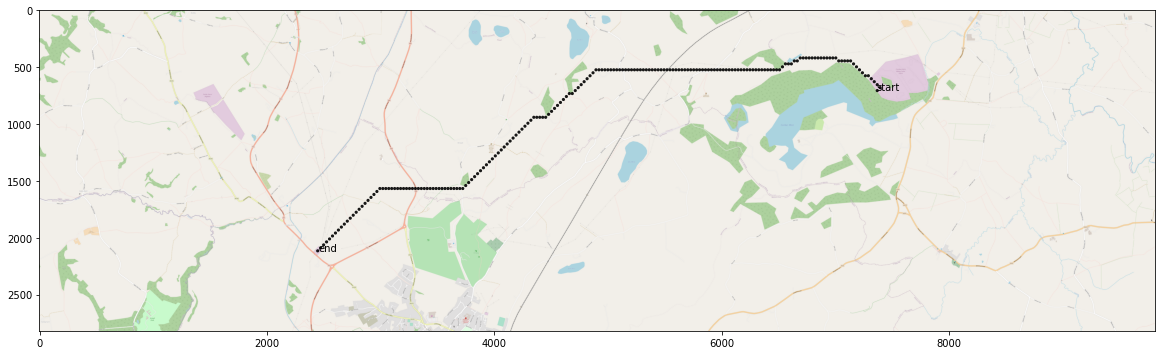

In [20]:
#-------------------# Display Path #-----------------#
# Setting heat_map to true results in a long wait time. Suggest using it in zoom < 14 and stations less than 10 km away
# Zoom 16 will be approriate for stations <1km away (Zoom must be changed at initial search, not below)
gen_map(bounding_box, plant_location, substation_location, shortest_path=shortest_path, zoom_level=zoom_level, heat_map=False)


In [0]:
from numpy import genfromtxt
import matplotlib.pyplot as plt
data13 = genfromtxt('zoom13.csv', delimiter=',')
data14 = genfromtxt('zoom14.csv', delimiter=',')
data15 = genfromtxt('zoom15.csv', delimiter=',')
data16 = genfromtxt('zoom16.csv', delimiter=',')
fig, ax1 = plt.subplots()

ax1.set_xlabel('k')
ax1.set_ylabel('Search Time (s)')
ax1.plot(data13[:,0], data13[:,4] , color='blue', label='Zoom 13', linestyle = ':')
ax1.plot(data14[:,0], data14[:,4] , color='green', label='Zoom 14', linestyle = ':')
ax1.plot(data15[:,0], data15[:,4] , color='orange', label='Zoom 15', linestyle = ':')
ax1.plot(data16[:,0], data16[:,4] , color='purple', label='Zoom 16', linestyle = ':')

ax1.plot(color='gray', label='Total Cost')

ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Total Cost (USD)')  # we already handled the x-label with ax1
ax2.plot(data13[:,0], data13[:,18] , color='blue')
ax2.plot(data14[:,0], data14[:,18] , color='green')
ax2.plot(data15[:,0], data15[:,18] , color='orange')

ax2.plot(data16[:,0], data16[:,18] , color='purple')

ax2.tick_params(axis='y')
fig.set_size_inches(8, 5)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True)
ax1.legend(loc='upper center')
plt.show()


OSError: ignored

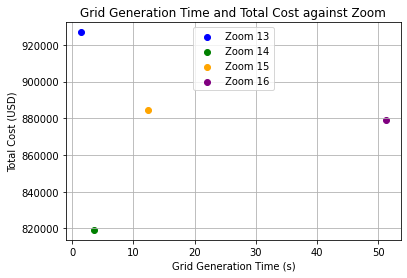

In [0]:
from numpy import genfromtxt
import matplotlib.pyplot as plt
nodestest = genfromtxt('nodestest.csv', delimiter=',')
plt.scatter(nodestest[1,3],nodestest[1,18], label = 'Zoom 13', color='blue')
plt.scatter(nodestest[2,3],nodestest[2,18], label = 'Zoom 14', color='green')
plt.scatter(nodestest[3,3],nodestest[3,18], label = 'Zoom 15', color='orange')
plt.scatter(nodestest[4,3],nodestest[4,18], label = 'Zoom 16', color='purple')

plt.title('Grid Generation Time and Total Cost against Zoom')
plt.xlabel('Grid Generation Time (s)')
plt.ylabel('Total Cost (USD)')
plt.legend()

plt.grid(True)
plt.legend(loc='upper center')
plt.show()

In [5]:
    import math
    for zoom in range(13,17):
      # The distance in meters of 1 pixel at a given zoom level (e.g 16) as output by geotiler:
      dist_per_pix = 40075016.686 * math.cos(math.radians(52)) / (2**(zoom + 8)) # 40075016.686 is the circumference of the earth in meters
      print('Distance per pixel', dist_per_pix)
      


      # The number of pixels along one axis of each square cell:
      grid_dist_pix = (38/dist_per_pix) # node_distm is the width of the overhead line to be constructed, the grid cells are therefore always 38mx38m
      print(grid_dist_pix)

Distance per pixel 11.764833401013913
3.229964990131105
Distance per pixel 5.8824167005069565
6.45992998026221
Distance per pixel 2.9412083502534783
12.91985996052442
Distance per pixel 1.4706041751267391
25.83971992104884
